In [ ]:
import os
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/kidney_refined_img.zip'
csv_file_path = '/content/drive/MyDrive/Coldsheet.csv'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kidney_refined_img')

extracted_files = os.listdir('/content/drive/MyDrive/kidney_refined_img')

scores_df = pd.read_csv(csv_file_path)
scores_df.head()

,Name of image,Score of 1 - 5
0,Cold Kidney 2,5
1,Cold Kidney 3,5
2,Cold Kidney 4,5
3,Cold Kidney 5,5
4,Cold Kidney 6,4


In [ ]:
scores_df.head()

,Name of image,Score of 1 - 5
0,Cold Kidney 2,5
1,Cold Kidney 3,5
2,Cold Kidney 4,5
3,Cold Kidney 5,5
4,Cold Kidney 6,4


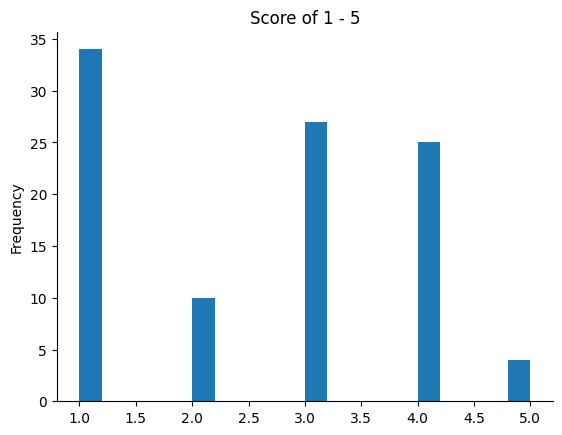

In [ ]:
# @title Score of 1 - 5

from matplotlib import pyplot as plt
scores_df['Score of 1 - 5'].plot(kind='hist', bins=20, title='Score of 1 - 5')
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Data Preparation**

In [ ]:
def load_and_preprocess_image(image_path):
    if os.path.isfile(image_path):
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    return None

In [ ]:
image_dir = '/content/drive/MyDrive/kidney_refined_img/images new'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, filename))]
image_arrays = [load_and_preprocess_image(path) for path in image_paths if load_and_preprocess_image(path) is not None]
image_arrays = np.vstack([img_array for img_array in image_arrays if img_array is not None])

In [ ]:
def format_filename(name):
    return os.path.splitext(name)[0].lower().strip()

In [ ]:
scores_df['formatted_name'] = scores_df['Name of image'].apply(format_filename)
# Map score according to images
name_to_score = dict(zip(scores_df['formatted_name'], scores_df['Score of 1 - 5']))

In [ ]:
# Cross the score with images and then create log file for those that is not matched
scores = []
not_found = []

for path in image_paths:
    if os.path.isfile(path):
        base_name = format_filename(os.path.basename(path))
        score = name_to_score.get(base_name, None)
        if score is not None:
            scores.append(score)
        else:
            not_found.append(os.path.basename(path))
            scores.append(-1)

if not_found:
    print("No scores found for the following files:")
    for file in not_found:
        print(file)
else:
    print("All files matched successfully.")

scores = np.array(scores)

All files matched successfully.


In [ ]:
valid_indices = [i for i, score in enumerate(scores) if score != -1]
image_arrays = image_arrays[valid_indices]
scores = np.array([scores[i] for i in valid_indices])

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert scores to one-hot encoding
scores_one_hot = to_categorical(scores - 1, num_classes=5)
model.fit(image_arrays, scores_one_hot, epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
4/4 [==============================] - 31s 7s/step - loss: 89.8052 - accuracy: 0.2400
Epoch 2/10
4/4 [==============================] - 24s 5s/step - loss: 43.2690 - accuracy: 0.6000
Epoch 3/10
4/4 [==============================] - 24s 5s/step - loss: 25.6061 - accuracy: 0.7200
Epoch 4/10
4/4 [==============================] - 23s 5s/step - loss: 5.7961 - accuracy: 0.8800
Epoch 5/10
4/4 [==============================] - 24s 5s/step - loss: 4.1876 - accuracy: 0.8900
Epoch 6/10
4/4 [==============================] - 25s 6s/step - loss: 0.4906 - accuracy: 0.9900
Epoch 7/10
4/4 [==============================] - 32s 9s/step - loss: 0.2203 - accuracy: 0.9800
Epoch 8/10
4/4 [==============================] - 27s 6s/step - loss: 0.3212 - accuracy: 0.9700
Epoch 9/10
4/4 [==============================] - 25s 6s/step - loss: 8.5104e-04 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 24s 5s/step - loss: 1.3948e-05 - accuracy: 1.0000


In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
resnet_model = model.get_layer('resnet50')
# Print all layer names
for layer in resnet_model.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
def load_and_preprocess_image(image_path):
    if os.path.isfile(image_path):
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    return None

In [ ]:
image_dir = '/content/drive/MyDrive/kidney_refined_img/images new'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, filename))]
image_arrays = [load_and_preprocess_image(path) for path in image_paths if load_and_preprocess_image(path) is not None]
image_arrays = np.vstack([img_array for img_array in image_arrays if img_array is not None])

Augmentation

In [ ]:
# Data augmentation configuration
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare data generator for augmentation
augmented_images, augmented_scores = [], []
for img_array, score in zip(image_arrays, scores):
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    aug_iter = data_gen.flow(img_array, batch_size=1)
    num_new_samples = 5  # Define how many augmented images you want per original image

    for _ in range(num_new_samples):
        aug_img = next(aug_iter)[0].astype('float32')  # Get augmented image
        augmented_images.append(aug_img)
        augmented_scores.append(score)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_scores = np.array(augmented_scores)


# **training and testing model**

In [ ]:
# Split the augmented dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_scores, test_size=0.2, random_state=42)

# Proceed as usual with training your model
y_train_one_hot = to_categorical(y_train - 1, num_classes=5)
y_test_one_hot = to_categorical(y_test - 1, num_classes=5)


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [ ]:
MyModel = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

MyModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
MyModel.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, shuffle = True)

Epoch 1/10
13/13 [==============================] - 99s 7s/step - loss: 42.2179 - accuracy: 0.3925
Epoch 2/10
13/13 [==============================] - 100s 8s/step - loss: 4.2634 - accuracy: 0.7575
Epoch 3/10
13/13 [==============================] - 97s 7s/step - loss: 0.5631 - accuracy: 0.9250
Epoch 4/10
13/13 [==============================] - 96s 7s/step - loss: 0.1748 - accuracy: 0.9625
Epoch 5/10
13/13 [==============================] - 95s 7s/step - loss: 0.1151 - accuracy: 0.9775
Epoch 6/10
 8/13 [=================>............] - ETA: 39s - loss: 0.0017 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
#Save the model
model_path = "/content/drive/MyDrive/Model/MyModel"
MyModel.save(model_path)


In [ ]:
# Saving training and test set

In [ ]:
# np.save('/content/drive/MyDrive/Model/X_train.npy', X_train)
# np.save('/content/drive/MyDrive/Model/X_test.npy', X_test)
# np.save('/content/drive/MyDrive/Model/y_train_one_hot.npy', y_train_one_hot)
# np.save('/content/drive/MyDrive/Model/y_test_one_hot.npy', y_test_one_hot)


In [ ]:
MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 74971013 (285.99 MB)
Trainable params: 51383301 (196.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# loading tarining and test set

In [ ]:
X_train = np.load('/content/drive/MyDrive/Model/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Model/X_test.npy')
y_train_one_hot = np.load('/content/drive/MyDrive/Model/y_train_one_hot.npy')
y_test_one_hot = np.load('/content/drive/MyDrive/Model/y_test_one_hot.npy')


In [ ]:
predictions = MyModel.predict(X_test)
predicted_scores = np.argmax(predictions, axis=1) + 1

1/1 [==============================] - 6s 6s/step


# Checking model accuracy on test set

In [ ]:
# Convert probabilities to class labels; the predicted class is the one with the highest probability
y_pred = np.argmax(predictions, axis=1)

# Since y_test_one_hot is one-hot encoded, we need to convert it back to class labels
y_true = np.argmax(y_test_one_hot, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 80.00%


# loading the model

In [ ]:
# Load the model
loaded_model = load_model('/content/drive/MyDrive/MyModel')
# Now you can use loaded_model to make predictions, evaluate, etc.

# **Extract Features from Each Convolutional Layer**

In [ ]:
#base_model.summary()

In [ ]:
# Load the base ResNet-50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Define the layers from which you want to extract features
layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
multi_output_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Initialize Global Average Pooling Layer
gap_layer = GlobalAveragePooling2D()

def extract_and_pool_features(image_tensor):
    # Expand the dimensions of the image tensor to include batch size
    image_tensor = np.expand_dims(image_tensor, axis=0)
    # Get the output from all layers
    features_per_layer = multi_output_model.predict(image_tensor)
    # Apply global average pooling to each layer's output and reshape to 1D
    pooled_features = [tf.reshape(gap_layer(feature), [-1]) for feature in features_per_layer]
    return pooled_features

# Example of processing image arrays and scores
features_by_layer = [[] for _ in range(len(layer_names))]  # Storage for features from each layer

for image_array in image_arrays:
    if image_array.ndim == 3:
        image_array = np.expand_dims(image_array, axis=0)

    if image_array.ndim != 4:
        continue  # Handle unexpected dimensions

    pooled_features = extract_and_pool_features(image_array[0])
    for i, features in enumerate(pooled_features):
        # Convert TensorFlow tensor to numpy array before appending
        features_by_layer[i].append(features.numpy())

# Convert feature lists to arrays
feature_arrays = [np.array(features) for features in features_by_layer]



# **Testing features in 2D array**

In [ ]:

# Assuming image_arrays contains your preprocessed images (as loaded and preprocessed earlier)
# Initialize ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Iterate over each layer of the model to extract features
for i, layer in enumerate(base_model.layers):
    # Create a new model that will output the features from the current layer
    model = Model(inputs=base_model.inputs, outputs=layer.output)

    # Initialize an empty list to store the flattened features for each image
    flattened_features = []

    # Iterate over your preprocessed images and extract the features
    for image in image_arrays:
    # Ensure the image has a batch dimension
    # image should be of shape (1, 224, 224, 3)
      if image.ndim == 3:
        image = np.expand_dims(image, axis=0)

    # Check if the image shape is now correct (1, 224, 224, 3)
      assert image.shape == (1, 224, 224, 3), "Image shape is incorrect"

    # Get the features for one image
      features = model.predict(image)

    # Flatten the features and append to the list
      flattened_features.append(features.flatten())


    # Combine the flattened features from all images into a 2D array
    features_array = np.array(flattened_features)

    # Ensure the shape is what you expect and save the array
    print(f"Shape for layer {i}: {features_array.shape}")
    # Save the features for this layer to disk
    np.save(f'features_layer_{i}.npy', features_array)


KeyboardInterrupt: 

# classifier for all 5 layers

In [ ]:
# Function to train and evaluate classifier
def train_and_evaluate(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy for {layer_name}: {accuracy:.2f}")

# Assuming 'scores' is defined and corresponds to the order of images
for i, feature_array in enumerate(feature_arrays):
    layer_name = layer_names[i]
    train_and_evaluate(feature_array, scores, layer_name)

Accuracy for conv1_relu: 0.50
Accuracy for conv2_block3_out: 0.60
Accuracy for conv3_block4_out: 0.60
Accuracy for conv4_block6_out: 0.60
Accuracy for conv5_block3_out: 0.50


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Function to train and evaluate multiple classifiers
def train_and_evaluate(features, scores, layer_name):
    X_train, X_test, y_train, y_test = train_test_split(features, scores, test_size=0.2, random_state=42)

    # Initialize classifiers
    classifiers = {
        'Gradient Boosting Machine': GradientBoostingClassifier(n_estimators=100),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Support Vector Machine': SVC(kernel='linear')
    }

    # Train and evaluate each classifier
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        results[name] = accuracy
        print(f"Accuracy for {layer_name} - {name}: {accuracy:.2f}")

    return results

# Assuming 'feature_arrays' and 'scores' are defined from previous image processing steps
for i, feature_array in enumerate(feature_arrays):
    layer_name = layer_names[i]
    print(f"Evaluating classifiers for features from layer: {layer_name}")
    train_and_evaluate(feature_array, scores, layer_name)
